The fold caustic expansion to first order satisfies (https://ui.adsabs.harvard.edu/abs/1986ApJ...310..568B/abstract )

$$\tau(x_I,y_I) = \tau_0 + \tau_x x_I + \tau_y y_I\\
+\frac{1}{2!}\tau_{xx} x_I^2 + \frac{1}{2}\tau_{yy} y_I^2 + \tau_{xy}(\tau_{xx},\tau_{yy}) x_I y_I\\
+\frac{1}{3!} \tau_{xxx} x_I^2\,,$$

where the first three terms can be set to zero, without loss of generality, because (a) the overall fermat potential $\tau_0$ is not directly measurable, and (b) we can define the image-plane coordinate system such that the potential is expanded at the origin and the origin maps to the origin in the source plane (i.e., $\vec \theta_0=\vec \beta_0=\vec \theta_0-\vec \alpha_0=(0,0)$).


Here the potential is expanded at around the critical point such that $\det |\partial \vec \beta/\partial \vec \theta|=0$, which yields $\tau_{xy}(\tau_{xx},\tau_{yy})=\pm (\tau_{xx} \tau_{yy})^{1/2}$. The effective fermat potential is then

$$\tau(x_I,y_I) = \frac{1}{2!}\tau_{xx} x_I^2 + \frac{1}{2!}\tau_{yy} y_I^2 + (\tau_{xx}\tau_{yy})^{1/2} x_I y_I +\frac{1}{3!} \tau_{xxx} x_I^3\,,$$

which is equivalent to expanding the deflection potential as

$$\psi(x_I,y_I) =\frac{1}{2!}\psi_{xx} x_I^2 + \frac{1}{2!}\psi_{yy} y_I^2 + ((1-\psi_{xx})(1-\psi_{yy}))^{1/2} x_I y_I +\frac{1}{3!} \psi_{xxx} x_I^3 $$

In [110]:
import numpy as np
import jax.numpy as jnp
import jax.scipy.spatial.transform
rotation = jax.scipy.spatial.transform.Rotation
import jax
import herculens as hcl
import helens
import pylab as plt
from caustics import FoldCausticPotential, CausticExpansion, create_rotation_matrix, get_critical_lines_caustics
from grid import create_grid
import scienceplots
plt.style.use(['science','ieee'])
# Enable jax double precision:
jax.config.update('jax_enable_x64', True)

In [111]:
# LENS MASS MODEL
kwargs_lens_list = [{"theta_E": 1.0, "e1": -0.2, "e2": 0.0, "center_x": 0.0, "center_y": 0.0}]
lens_mass_model = hcl.MassModel([hcl.SIE()]) # Define the fold caustic lens

In [112]:
# GRID
xmin, xmax, ymin, ymax = -2, 2, -2, 2; nx, ny = 300, 300
pixel_grid, grid_x, grid_y, x, y = create_grid(xmin, xmax, ymin, ymax, nx, ny)
# Compute the magnifications:
mu = lens_mass_model.magnification(x, y, kwargs_lens_list)
Mu = lens_mass_model.magnification(grid_x, grid_y, kwargs_lens_list)
# Compute caustics
crit_lines, caustics = get_critical_lines_caustics(lens_mass_model, kwargs_lens_list, pixel_grid)

In [113]:
# Compute eigenvectors at the caustics:
caustic_expansion = CausticExpansion(lens_mass_model, kwargs_lens_list)
x0, y0 = crit_lines[0][0][150], crit_lines[0][1][150] # A point on the critical curve
v1, v2, lambda1, lambda2 = caustic_expansion.get_inverse_magnification_eigenvectors(x0, y0)
nabla_detA, nabla_detA_rot = caustic_expansion.get_nabla_detA(x0, y0)
R=create_rotation_matrix(vec_original=v2, vec_target=jnp.array([0.0, 1.0]))
f_ij, f_ijk = caustic_expansion.get_derivatives_to_third(x0, y0, R=R)

In [114]:
f_ij

Array([[1.00000117e+00, 1.32276708e-06],
       [1.32276708e-06, 7.78966081e-11]], dtype=float64)

In [115]:
f_ijk[1,1,1], f_ijk[1,1,0], f_ijk[1,0,0], f_ijk[0,0,0]

(Array(1.34751252e-10, dtype=float64),
 Array(2.26281385e-06, dtype=float64),
 Array(0.85533462, dtype=float64),
 Array(0.26113646, dtype=float64))

In [91]:
f_ijk[0,0,0], f_ijk[1,1,1], f_ijk[1,1,0], f_ijk[1,0,0], f_ijk[0,0,1], f_ijk[0,1,1], f_ij[0,0], f_ij[1,1], f_ij[0,1]

(Array(1.3475124e-10, dtype=float64),
 Array(-0.26113646, dtype=float64),
 Array(0.85533462, dtype=float64),
 Array(-2.26281385e-06, dtype=float64),
 Array(-2.26281385e-06, dtype=float64),
 Array(0.85533462, dtype=float64),
 Array(7.78966171e-11, dtype=float64),
 Array(1.00000117, dtype=float64),
 Array(-1.32276708e-06, dtype=float64))

In [83]:
f = lambda x,y: lens_mass_model.potential(x,y, kwargs_lens_list)


In [69]:
# Compute the image positions:
x_src, y_src = 0.0, 0.0
# Compute numerically
ray_shooting_func = lens_mass_model.ray_shooting
lens_eq_solver = helens.LensEquationSolver(grid_x, grid_y, ray_shooting_func)
beta   = jnp.array([x_src, y_src])
img, src = lens_eq_solver.solve(beta, kwargs_lens_list, nsolutions=5, niter=5, nsubdivisions=8)

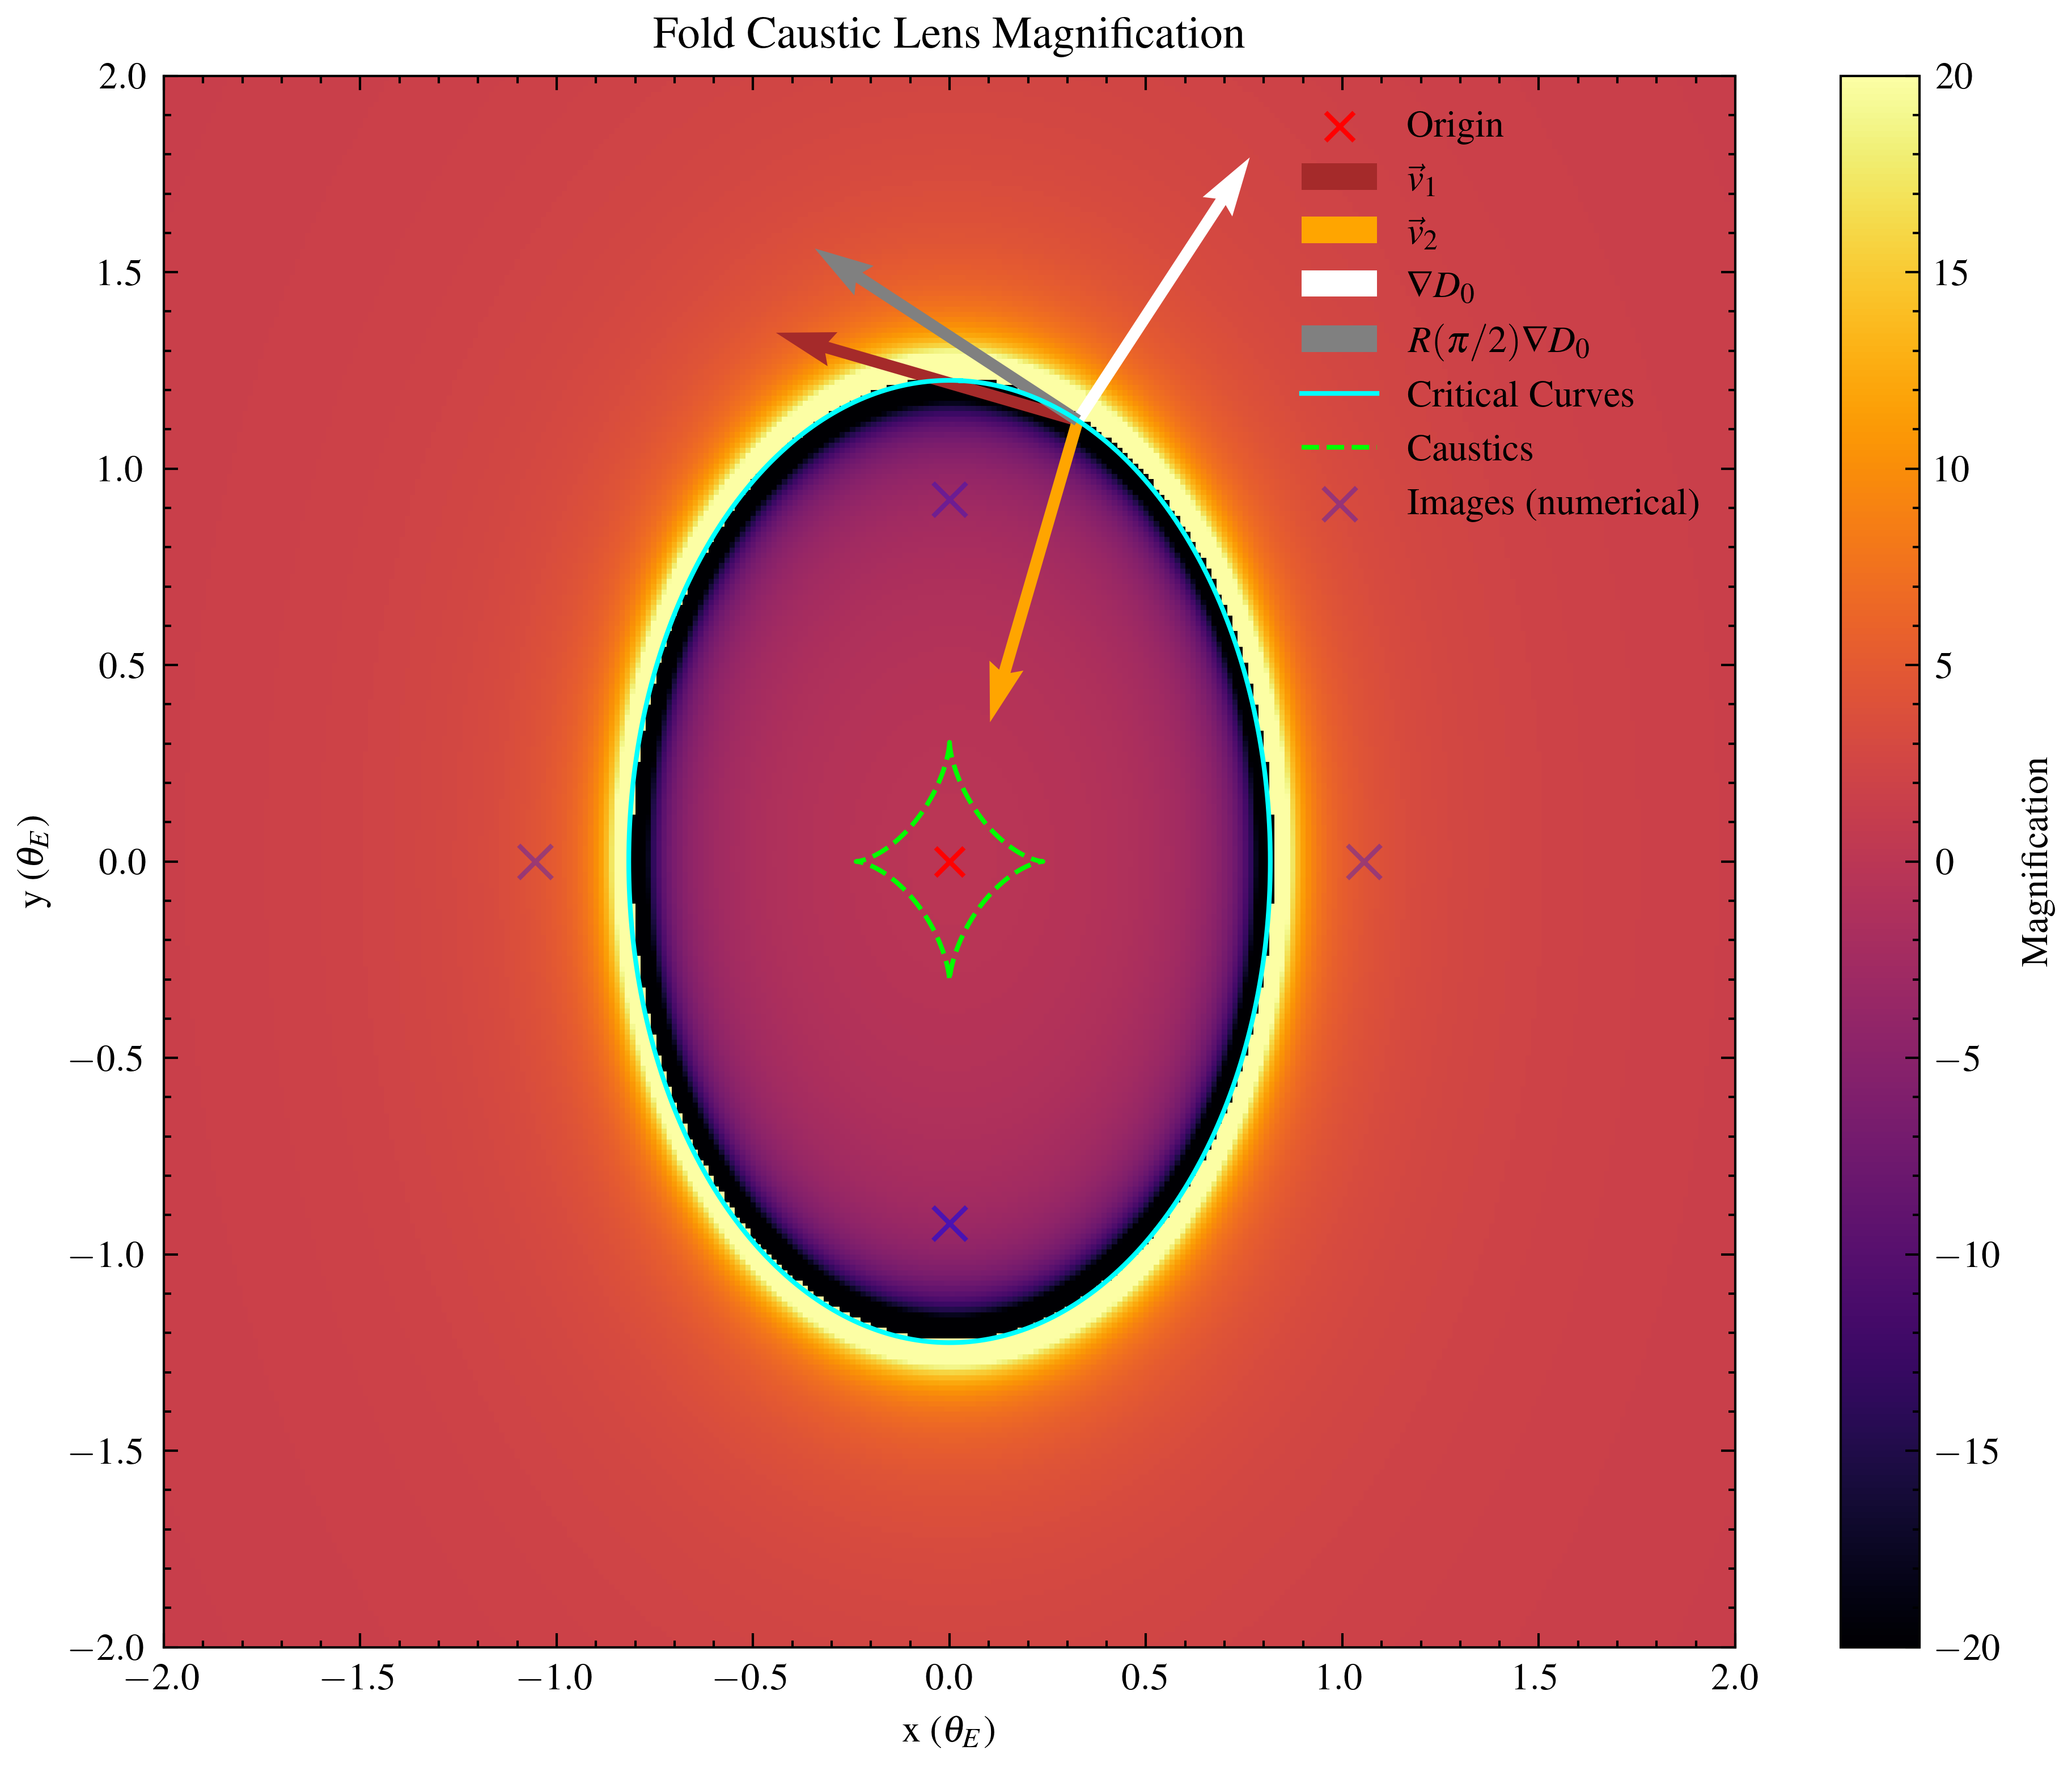

In [70]:
# Plot the absolute value of the magnification, the image positions, and eigenvectors:
plt.figure(figsize=(8, 6))
im = plt.imshow(Mu, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='inferno', vmin=-20, vmax=20) # Magnifications
cbar = plt.colorbar(im)
cbar.set_label('Magnification')
plt.scatter(0,0, marker='x', color='red', label='Origin') # Source positions
# Plot eigenvectors from 0:
plt.quiver(x0, y0, v1[0], v1[1], color='brown', scale=5, label=r"$\vec v_1$")
plt.quiver(x0, y0, v2[0], v2[1], color='orange', scale=5, label=r"$\vec v_2$")
# Plot the nabla_detA vector from 0:
plt.quiver(x0, y0, nabla_detA[0]/np.linalg.norm(nabla_detA), nabla_detA[1]/np.linalg.norm(nabla_detA), 
           color='white', scale=5, label=r"$\nabla D_0$")
# Plot the rotated nabla_detA vector from 0:
plt.quiver(x0, y0, nabla_detA_rot[0]/np.linalg.norm(nabla_detA_rot), nabla_detA_rot[1]/np.linalg.norm(nabla_detA_rot), 
           color='gray', scale=5, label=r"$R(\pi/2) \nabla D_0$")
# Plot critical curves and caustics:
plt.plot(crit_lines[0][0], crit_lines[0][1], color='cyan', lw=1, label='Critical Curves') # Critical curves
plt.plot(caustics[0][0], caustics[0][1], color='lime', lw=1, label='Caustics') # Caustics
# Plot the images:
plt.scatter(img[:,0], img[:,1], color='blue', s=50, marker='x', label='Images (numerical)', alpha=0.3) # Images as crosses
plt.xlabel(r"x ($\theta_E$)")
plt.ylabel(r"y ($\theta_E$)")
plt.title('Fold Caustic Lens Magnification')
plt.legend()
plt.show()

In [65]:
_psf = hcl.PSF(psf_type="NONE")#psf_type='GAUSSIAN', fwhm=0.1, pixel_size=pixel_grid.pi)
lens_image = hcl.LensImage(lens_mass_model_class=lens_mass_model, grid_class=pixel_grid, psf_class=_psf)
crit_lines, caustics = hcl.Util.model_util.critical_lines_caustics(lens_image, kwargs_lens_list)


In [64]:
crit_lines

[(array([0.02844566, 0.02933333, 0.032     , ..., 0.024     , 0.02666667,
         0.02844566], shape=(3065,)),
  array([1.224     , 1.22395439, 1.22380431, ..., 1.22421614, 1.22409177,
         1.224     ], shape=(3065,))),
 (array([ 4.44089210e-16, -2.66666667e-03,  4.44089210e-16,  2.66666667e-03,
          4.44089210e-16]),
  array([ 0.00266667,  0.        , -0.00266667,  0.        ,  0.00266667]))]